In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.io import wavfile
import librosa
import librosa.display
import plotly.express as px
%matplotlib inline
# My library
from dataset_tools import *
from utils import *



import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

database_path = "../data_acquisition/database.csv"
dataset_path = "../data_acquisition/samples_dataset"


audio_sample_rate = 44100

ModuleNotFoundError: No module named 'librosa'

In [2]:
samplerate, ex_data = wavfile.read('../data_acquisition/samples_dataset/0.wav')
ex_data_mono = ex_data.transpose()[0]

# Static visuals of the sample

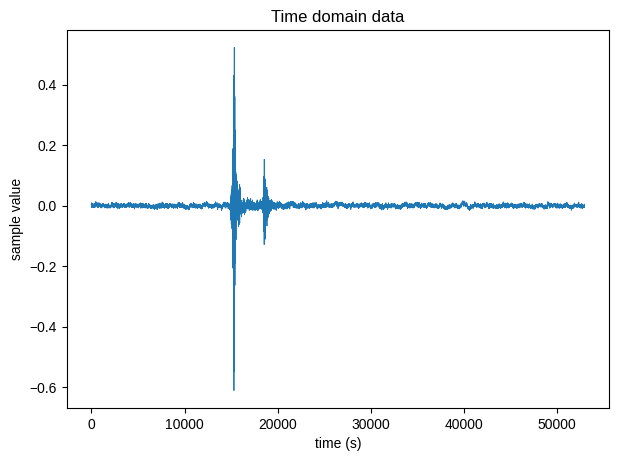

In [3]:

# Import my file for visuals:



plot_time_data(ex_data_mono)

In [4]:
# Get fft data of the sample
fft_ex_data = np.fft.fft(ex_data_mono)
fft_ex_data_mag = np.abs(fft_ex_data)
freq = np.linspace(0, audio_sample_rate, len(fft_ex_data_mag))

# plot_fft_data(freq,fft_ex_data_mag,ylog=True,xlog=False)

In [5]:
plot_fft_data_plotly(freq,fft_ex_data_mag,ylog=True,xlog=False)

## Moving FFT

In [6]:
# Calculate
n_fft = 2048
hop_length = 512

sfft = librosa.core.stft(ex_data_mono, hop_length=hop_length, n_fft=n_fft )

spectrogram = np.abs(sfft)
db_spectrogram = librosa.amplitude_to_db(spectrogram)

In [7]:
np.shape(spectrogram)

len(spectrogram[0])

104

In [8]:
# Plotting
import plotly.express as px

fig = px.imshow(db_spectrogram,color_continuous_scale='RdBu_r',labels={'x':'Time', 'y':'Freqency'})
# fig = px.imshow(spectrogram,labels={'x':' (Hz)', 'y':'Magnutude'})
fig.update_yaxes(autorange=True)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()

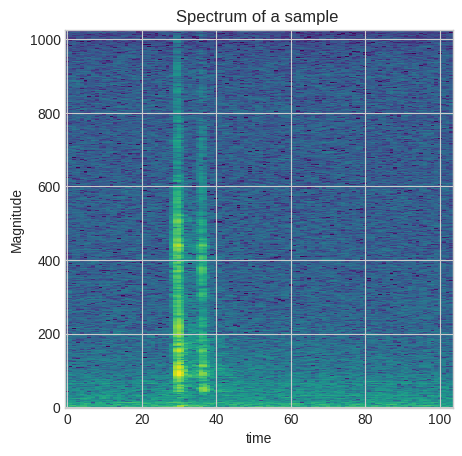

In [9]:
# My matplotlib plot:
plot_spectrum(db_spectrogram)

Text(0, 0.5, 'Freq')

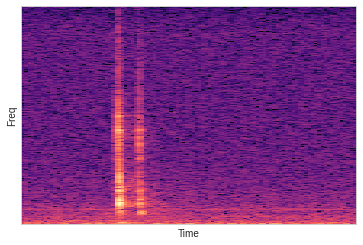

In [10]:
librosa.display.specshow(db_spectrogram,sr=audio_sample_rate,hop_length=hop_length )
plt.xlabel("Time")
plt.ylabel("Freq")

## Mel Spectrogram
https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505

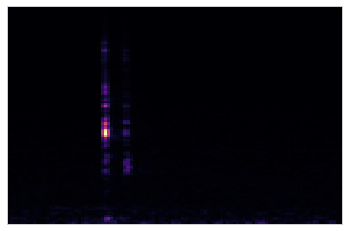

In [11]:
# use the mel-scale instead of raw frequency
sgram_mag, _ = librosa.magphase(sfft)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=audio_sample_rate)
librosa.display.specshow(mel_scale_sgram)

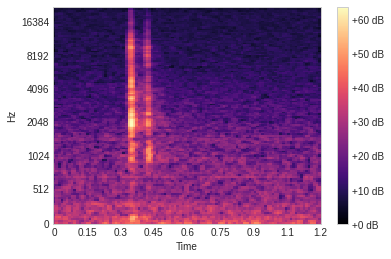

In [44]:
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=audio_sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

# Preprocessing itself

Creating dataset out of samples

In [16]:
import preprocess
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

In [25]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

class AudioUtil():
    # ----------------------------
    # Load an audio file. Return the signal as a tensor and the sample rate
    # ----------------------------
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)

In [30]:
class SoundDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    # audio_file = self.data_path + self.df.loc[idx, 'path']
    audio_file = os.path.join( self.data_path ,  self.df.loc[idx, 'path'])
    # Get the Class ID
    class_id = self.df.loc[idx, 'key_pressed']

    aud = AudioUtil.open(audio_file)
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same 
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
    # reaud = AudioUtil.resample(aud, self.sr)
    # rechan = AudioUtil.rechannel(reaud, self.channel)

    # dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    # shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None)
    # aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return sgram, class_id
  
  

In [1]:
# Very important. Sorting dataset:

# test_keys = ["q","w","e","r","t","y","u","i","o","p","a","s","d","f","g","h","j","k","l","z","x","c","v","b","n","m"]
test_keys = ["w","f","x","k","y"]
test_len = 52920

In [2]:
import pandas as pd
df = pd.read_csv("../data_acquisition/dataset.csv").set_index('id')
df.head(2)

path key_pressed  num_of_samples  time_created  comment
id                                                                          
0   samples_dataset/0.wav           y           52920    1660426816      NaN
1   samples_dataset/1.wav           l           52920    1660426819      NaN

In [3]:
# Dataset filter
df_for_dataset = df.loc[(df["num_of_samples"] == 52920 ) &  (df["key_pressed"].isin(test_keys)) ]

In [4]:
# df_for_dataset.loc[df["num_of_samples"] != 52920]
df_for_dataset.head(5)

path key_pressed  num_of_samples  time_created  comment
id                                                                          
0   samples_dataset/0.wav           y           52920    1660426816      NaN
2   samples_dataset/2.wav           k           52920    1660426822      NaN
6   samples_dataset/6.wav           x           52920    1660426835      NaN
7   samples_dataset/7.wav           x           52920    1660426838      NaN
8   samples_dataset/8.wav           x           52920    1660426840      NaN

In [5]:
len(df_for_dataset)/len(test_keys)

94.6

In [32]:
dataset = SoundDS(df_for_dataset,"../data_acquisition")

In [62]:
dataset[0][0].shape

torch.Size([2, 64, 104])

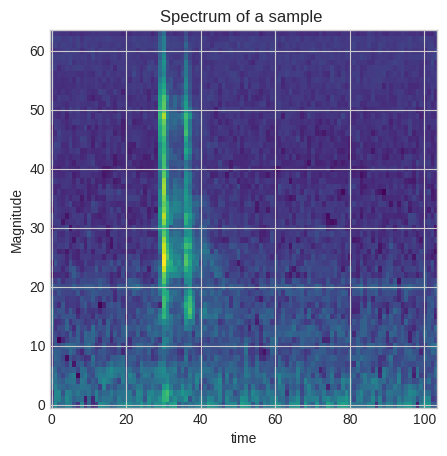

In [59]:
plot_spectrum(dataset[0][0][1])

# Working with model itself

In [ ]:
# Dataset prep
from torch.utils.data import random_split

myds = dataset

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

In [ ]:
import torch.nn.functional as F
from torch.nn import init

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device